In [1]:
import sys
sys.path.append('../..')
from src.pomdp import *

import pandas as pd
import numpy as np
import cupy as cp

In [2]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(3)

# Model definition

In [3]:
olf_stats = np.load('./Data/statistics_nose_3e6_27_123.npy')

In [4]:
olf_shape = olf_stats.shape
margins = [14, 62]

height = olf_shape[0] + margins[0]*2
width = olf_shape[1] + margins[1]*2

env_shape = [height, width]
state_count = width * height
print(f'Environment shape: {env_shape}')
print(f'State count: {state_count}')

Environment shape: [56, 247]
State count: 13832


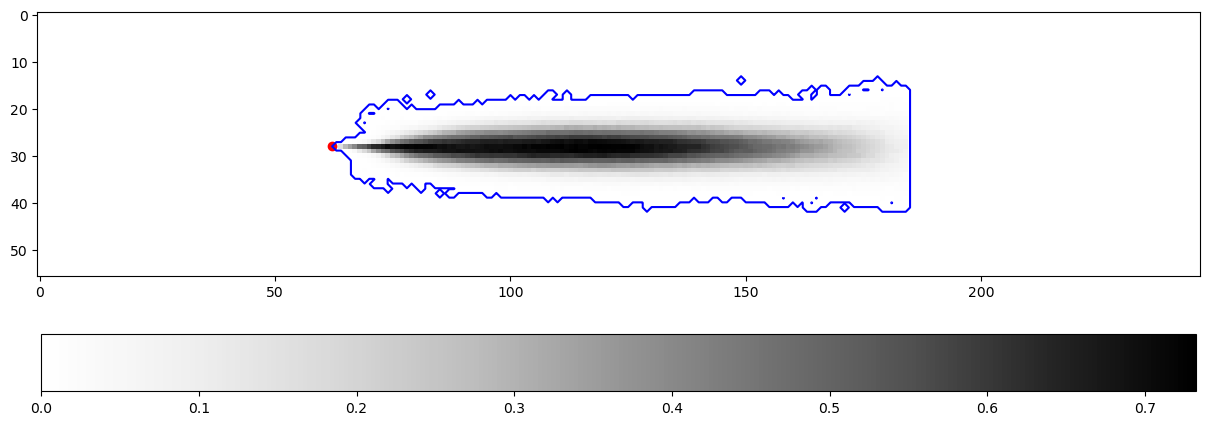

In [5]:
nose_data = np.zeros(env_shape)

nose_data[margins[0]:margins[0]+olf_shape[0], margins[1]:margins[1]+olf_shape[1]] = olf_stats

plt.figure(figsize=(15,5))
plt.imshow(nose_data, cmap='Greys')
plt.colorbar(location='bottom', orientation='horizontal')
plt.contour(nose_data > 0.00, levels=[0.1], colors='blue')
plt.scatter(62,28, c='red')

In [6]:
# goal states
source = [28,62]
goal_state = (source[0] * env_shape[1]) + source[1]

print(f'Goal state: {goal_state}')

Goal state: 6978


In [7]:
# Computing end states in radius of source
source_radius = 2
end_states = np.argwhere(np.fromfunction(lambda x,y: ((x-source[0])**2 + (y-source[1])**2) <= source_radius**2, shape=env_shape).ravel())[:,0].tolist()

for es in end_states:
    reverse_index = np.unravel_index(es, shape=env_shape)
    print(f'{es} - [{reverse_index[0]}, {reverse_index[1]}]')

6484 - [26, 62]
6730 - [27, 61]
6731 - [27, 62]
6732 - [27, 63]
6976 - [28, 60]
6977 - [28, 61]
6978 - [28, 62]
6979 - [28, 63]
6980 - [28, 64]
7224 - [29, 61]
7225 - [29, 62]
7226 - [29, 63]
7472 - [30, 62]


In [8]:
end_state_positions = np.array([np.unravel_index(es, shape=env_shape) for es in end_states])

In [9]:
# observation matrix
observations = np.empty((state_count, 5, 3)) # 5-actions, 3-observations

# obs 0: Nothing observed, obs 1: Something observed, obs 2: source found

observations[:,:,0] = (1 - nose_data.ravel()[:,None])
observations[:,:,1] = nose_data.ravel()[:,None]

# Detection of goal
observations[:,:,2] = 0.0
observations[end_states,:,:] = 0.0
observations[end_states,:,2] = 1.0

In [10]:
# states
state_grid = []

# State labels
for i in range(env_shape[0]):
    i_states = []
    for j in range(env_shape[1]):
        i_states.append(f's_{i}_{j}')

    state_grid.append(i_states)

In [11]:
# Reachable states
row_w = env_shape[1]

reachable_states = np.zeros((state_count, 5, 1), dtype=int)
for s in range(state_count):
    reachable_states[s,0,0] = s - row_w if s - row_w >= 0 else (state_count - row_w) + s # North
    reachable_states[s,1,0] = s + 1 if (s + 1) % row_w > 0 else s # East
    reachable_states[s,2,0] = s + row_w if s + row_w < state_count else s % row_w # South
    reachable_states[s,3,0] = s - 1 if (s - 1) % row_w < (row_w - 1) else s # West
    reachable_states[s,4,0] = s # Doesn't move

reachable_states = np.array(reachable_states)

In [12]:
# Start belief
start = ((nose_data > 0.00) & np.fromfunction(lambda y,x: x > source[1] + source_radius, shape=env_shape)).astype(float)
start /= np.sum(start)

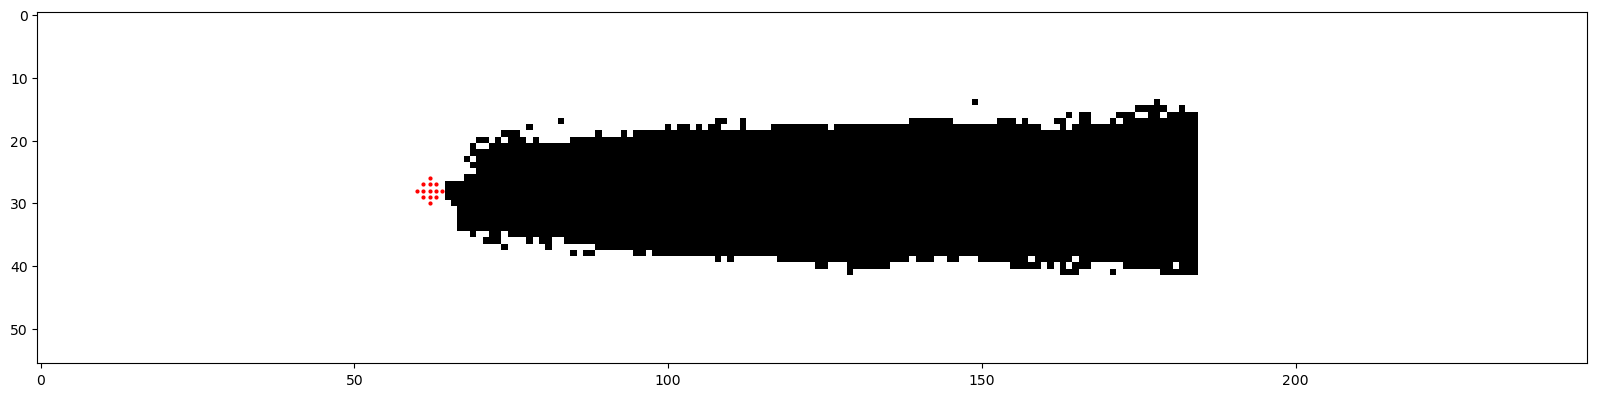

In [13]:
# Plotting end positions and start probabilities
plt.figure(figsize=(20,5))
plt.imshow(start, cmap='Greys')
plt.scatter(end_state_positions[:,1], end_state_positions[:,0], s=4, c='red')

In [14]:
model = Model(
    states=state_grid,
    actions=['N','E','S','W','O'],
    observations=['nothing','something','goal'],
    reachable_states=reachable_states,
    # rewards=reward_func,
    observation_table=observations,
    end_states=end_states,
    start_probabilities=start.ravel()
)

[02/08/2024, 17:22:59] Instantiation of MDP Model:
[02/08/2024, 17:22:59] - 13832 states
[02/08/2024, 17:22:59] - 5 actions
[02/08/2024, 17:22:59] - At most 1 reachable states per state-action pair
[02/08/2024, 17:22:59] - Starting generation of transitions table
[02/08/2024, 17:22:59]     > [Warning] No transition matrix or function provided but reachable states are, so probability to reach any reachable states will "1 / reachable state count" so here: 1.000.
[02/08/2024, 17:22:59]     > Done in 0.000s
[02/08/2024, 17:22:59] - Generation of state grid
[02/08/2024, 17:22:59] - Generating start probabilities table
[02/08/2024, 17:22:59] - Starting computation of reachable state probabilities from transition data
[02/08/2024, 17:22:59]     > Done in 0.000s

[02/08/2024, 17:22:59] POMDP particular parameters:
[02/08/2024, 17:22:59] - 3 observations
[02/08/2024, 17:22:59] - Starting of transitional observations for reachable states table
[02/08/2024, 17:22:59]     > Done in 0.005s
[02/08/2

In [15]:
# model.save('Nose_Only_27_123')

# FSVI Solving

In [16]:
fsvi_solver = FSVI_Solver(0.99, eps=1e-6)

In [17]:
fsvi_solution, hist = fsvi_solver.solve(model=model,
                                        expansions=600,
                                        max_belief_growth=100,
                                        # prune_level=2, # Useless because of belief domination
                                        # prune_interval=25,
                                        # history_tracking_level=2,
                                        use_gpu=True)
print(hist.summary)

[02/07/2024, 18:19:43] Sending Model to GPU...
[02/07/2024, 18:19:43]     > Done in 0.253s
[02/07/2024, 18:19:43] [Warning] MDP solution not provided, running value iteration on the problem to retrieve it...
[02/07/2024, 18:19:43]     > Starting MDP Value Iteration...
[02/07/2024, 18:19:44]     > Value Iteration stopped or converged in 0.879s, and after 918 iteration.



Expansions:   0%|          | 0/600 [00:00<?, ?it/s]

Memory full: Out of memory allocating 20,821,032,960 bytes (allocated so far: 63,537,732,096 bytes).
Returning value function and history as is...

Summary of Value Iteration run
  - Model: 13832 state, 5 action, 3 observations
  - Converged or stopped after 556 expansion steps and 555 backup steps.
  - Resulting value function has 12544 alpha vectors.
  - Converged in 341.3533s

  - Expand function took on average 0.0606s and yielded on average 69.34 beliefs per iteration. (0.0009s/it/belief)
  - Backup function took on average 0.5544s and yielded on average 22.59 alpha vectors per iteration. (0.0002s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


[Warning] Value function on GPU, converting to numpy before plotting...
[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


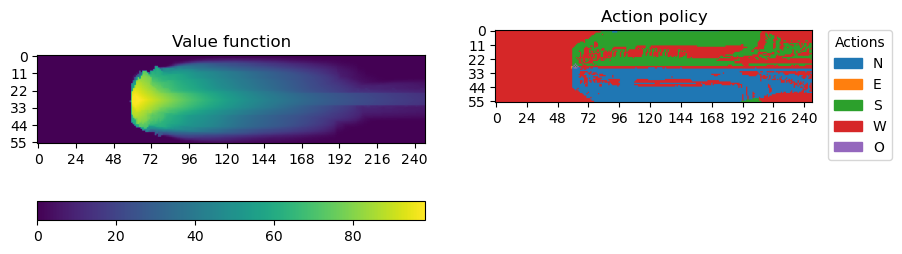

In [18]:
fsvi_solution.plot()

In [19]:
# fsvi_solution.save_parquet()

# Run grid test

In [15]:
fsvi_solution = ValueFunction.load_from_parquet('./ValueFunctions/20240207_182536_value_function.parquet', model)

In [20]:
a = Agent(model=model.gpu_model, value_function=fsvi_solution.to_gpu())

In [21]:
start_positions = np.argwhere(model.start_probabilities > 0)[:,0].tolist()

In [22]:
_, all_sims = a.run_n_simulations_parallel(n=len(start_positions), max_steps=400, start_state=start_positions)

  0%|          | 0/400 [00:00<?, ?it/s]

All 2483 simulations done in 175.565s:
	- Simulations reached goal: 2480/2483 (3 failures)
	- Average step count: 81.35602094240838
	- Average total rewards: 0.9987917841320982
	- Average discounted rewards (ADR): 0.47475753189297065


In [24]:
# Saving simulation
import json

all_seq = np.empty((len(all_sims), 401), dtype=object)
for sim_i, sim in enumerate(all_sims):
    seq = []
    for s, a, o, r in zip(sim.states, sim.actions+[], sim.observations+[], sim.rewards+[]):
        seq.append(json.dumps({'s':s, 'a':a, 'o':o, 'r':r}))
    
    all_seq[sim_i, :len(seq)] = seq

sim_df = pd.DataFrame(all_seq.T, columns=[f'Sim-{sim_i}' for sim_i in range(len(all_sims))])
sim_df.to_csv(f'./run-q_learning_comp-sims.csv')

In [25]:
failed_sims = [sim for sim in all_sims if len(sim) == 401]    

In [26]:
for i,sim in enumerate(all_sims):
    if len(sim) == 401:
        print(i)

791
1382
1742


In [27]:
from viz_functions import plot_steps

In [28]:
# failed_sims[0].states[:100]

In [34]:
end_states

[6484, 6730, 6731, 6732, 6976, 6977, 6978, 6979, 6980, 7224, 7225, 7226, 7472]

In [31]:
len(failed_sims[0])

1001

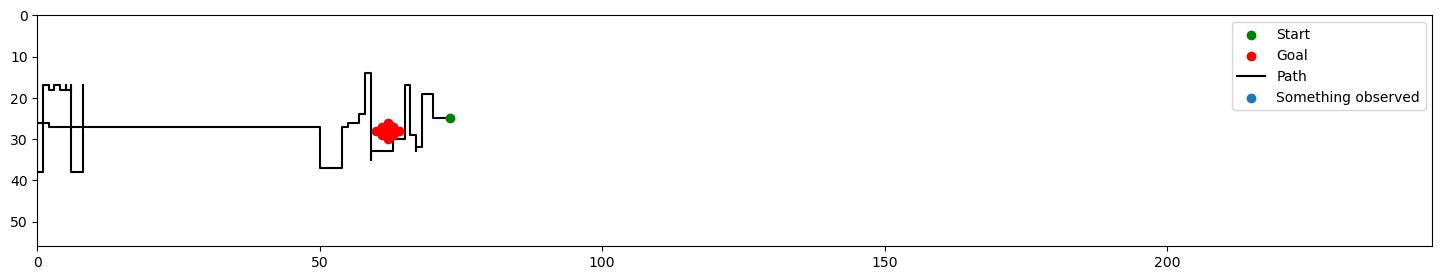

In [33]:
plot_steps(failed_sims[0])

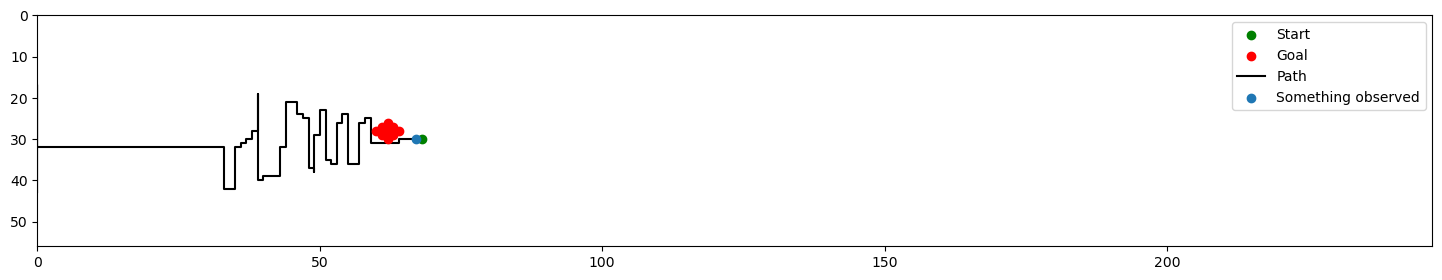

In [32]:
plot_steps(failed_sims[1])

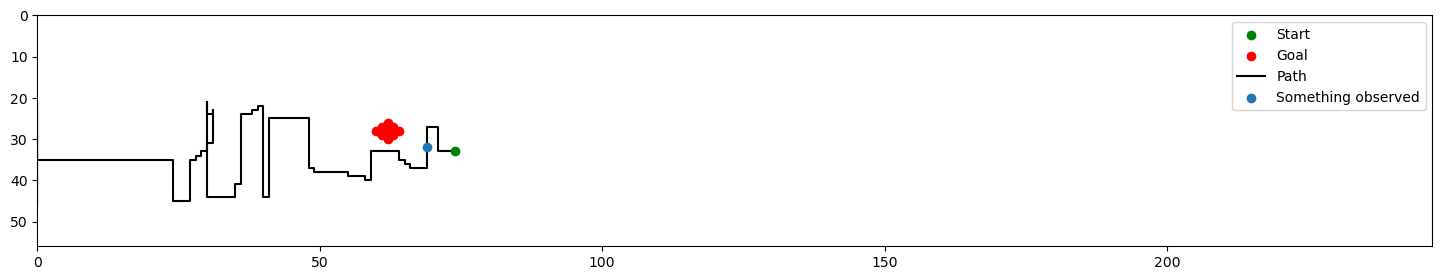

In [34]:
plot_steps(failed_sims[2])

# Loading simulations

In [15]:
from util_functions import load_simulations_from_csv

In [16]:
all_sims = load_simulations_from_csv('./Test_Results/Test_Q_Learning_comparison/run-q_learning_comp-sims.csv', model)

/home/arnaud/POMDP_PBVI_Exploration/Experiments/Olfactory Navigation/util_functions.py:90: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,24

In [18]:
from viz_functions import plot_steps

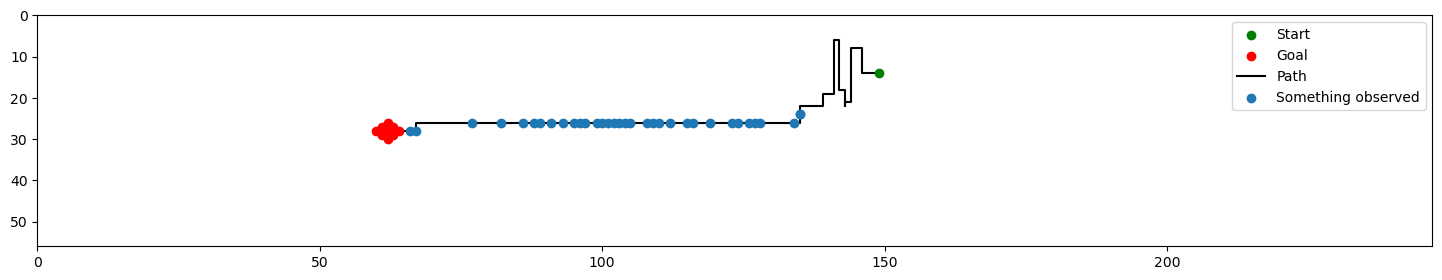

In [19]:
plot_steps(all_sims[0])

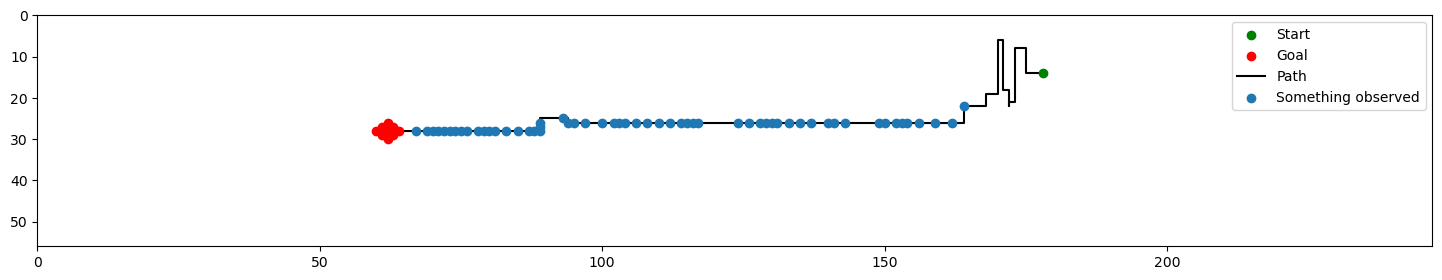

In [20]:
plot_steps(all_sims[1])

In [46]:
sim_stats_df = pd.DataFrame()

# Sim start
sim_stats_df['start_id'] = [sim.states[0] for sim in all_sims]
sim_stats_df['start_x'] = [np.unravel_index(sim.states[0], env_shape)[1] for sim in all_sims]
sim_stats_df['start_y'] = [np.unravel_index(sim.states[0], env_shape)[0] for sim in all_sims]

# Steps and convergence
sim_stats_df['steps_taken'] = [len(sim) for sim in all_sims]
sim_stats_df['opt_steps'] = np.abs(sim_stats_df['start_x'] - source[1]) + np.abs(sim_stats_df['start_y'] - source[0])
sim_stats_df['converged'] = [len(sim) != 400 for sim in all_sims]

# Measures
sim_stats_df['Tmin_over_T'] = sim_stats_df['opt_steps'] / sim_stats_df['steps_taken']
sim_stats_df['extra_steps'] = sim_stats_df['steps_taken'] - sim_stats_df['opt_steps']

In [47]:
sim_stats_df_filt = sim_stats_df[sim_stats_df['converged']]
print(f'Simulation stats over {len(sim_stats_df)} simulations:')
print(f'  - Convergence {len(sim_stats_df_filt) * 100 / len(sim_stats_df):.2f}%')
print(f'  - T_min over T: {sim_stats_df["Tmin_over_T"].mean():.3f} (filtered: {sim_stats_df_filt["Tmin_over_T"].mean():.3f})')
print(f'  - Extra steps: {sim_stats_df["extra_steps"].mean():.3f} (filtered: {sim_stats_df_filt["extra_steps"].mean():.3f})')

Simulation stats over 2483 simulations:
  - Convergence 99.88%
  - T_min over T: 0.912 (filtered: 0.913)
  - Extra steps: 7.924 (filtered: 7.465)


In [49]:
# Saving stats
sim_stats_df.to_csv('./Test_Results/Test_Q_Learning_Comparison/run-q_learning_comp-sims_stats.csv')

# Real simulation

In [16]:
fsvi_solution = ValueFunction.load_from_parquet('./Test_Results/Test_Q_Learning_Comparison/20240207_182536_value_function.parquet', model)

In [17]:
a = Agent(model=model.gpu_model, value_function=fsvi_solution.to_gpu())

[02/08/2024, 17:23:25] Sending Model to GPU...
[02/08/2024, 17:23:25]     > Done in 0.371s


In [18]:
from simulations import RealSimulationSetQComp

In [19]:
start_positions = np.argwhere(model.start_probabilities > 0)[:,0].tolist()

In [20]:
_, all_sims = a.run_n_simulations_parallel(n=len(start_positions),
                                           simulator_set=RealSimulationSetQComp(model.gpu_model, '/storage/rando/data/nose_data_27_123.npy'),
                                           max_steps=400,
                                           start_state=start_positions)

  0%|          | 0/400 [00:00<?, ?it/s]

All 2483 simulations done in 295.686s:
	- Simulations reached goal: 2471/2483 (12 failures)
	- Average step count: 91.83205799436166
	- Average total rewards: 0.9951671365283931
	- Average discounted rewards (ADR): 0.4492252736687401


In [21]:
from util_functions import save_simulations_to_csv

In [22]:
# Saving simulations
save_simulations_to_csv('./Test_Results/Test_Q_Learning_Comparison/run-q_learning_comp-real_data-sims.csv', all_sims)

[02/08/2024, 17:29:27] Saving simulation logs


In [23]:
sim_stats_df = pd.DataFrame()

# Sim start
sim_stats_df['start_id'] = [sim.states[0] for sim in all_sims]
sim_stats_df['start_x'] = [np.unravel_index(sim.states[0], env_shape)[1] for sim in all_sims]
sim_stats_df['start_y'] = [np.unravel_index(sim.states[0], env_shape)[0] for sim in all_sims]

# Steps and convergence
sim_stats_df['steps_taken'] = [len(sim) for sim in all_sims]
sim_stats_df['opt_steps'] = np.abs(sim_stats_df['start_x'] - source[1]) + np.abs(sim_stats_df['start_y'] - source[0])
sim_stats_df['converged'] = [len(sim) != 400 for sim in all_sims]

# Measures
sim_stats_df['Tmin_over_T'] = sim_stats_df['opt_steps'] / sim_stats_df['steps_taken']
sim_stats_df['extra_steps'] = sim_stats_df['steps_taken'] - sim_stats_df['opt_steps']

In [24]:
sim_stats_df_filt = sim_stats_df[sim_stats_df['converged']]
print(f'Simulation stats over {len(sim_stats_df)} simulations:')
print(f'  - Convergence {len(sim_stats_df_filt) * 100 / len(sim_stats_df):.2f}%')
print(f'  - T_min over T: {sim_stats_df["Tmin_over_T"].mean():.3f} (filtered: {sim_stats_df_filt["Tmin_over_T"].mean():.3f})')
print(f'  - Extra steps: {sim_stats_df["extra_steps"].mean():.3f} (filtered: {sim_stats_df_filt["extra_steps"].mean():.3f})')

Simulation stats over 2483 simulations:
  - Convergence 100.00%
  - T_min over T: 0.835 (filtered: 0.835)
  - Extra steps: 19.400 (filtered: 19.400)


In [25]:
# Saving stats
sim_stats_df.to_csv('./Test_Results/Test_Q_Learning_Comparison/run-q_learning_comp-real_data-sims_stats.csv')

In [27]:
from viz_functions import plot_steps

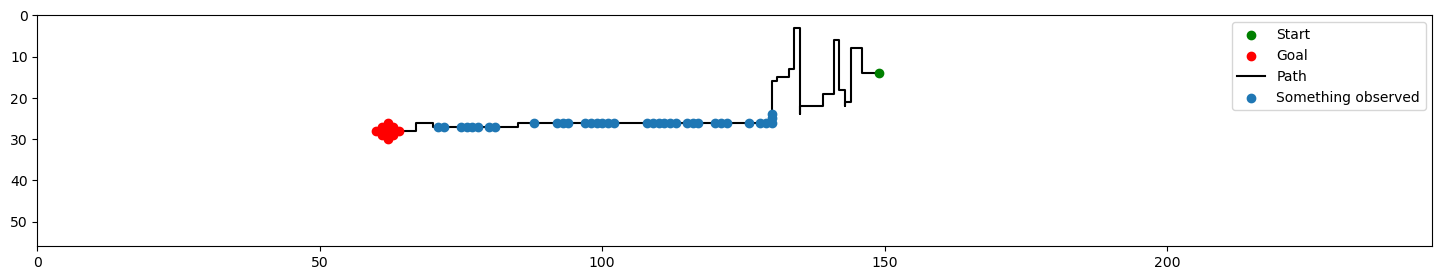

In [28]:
plot_steps(all_sims[0])

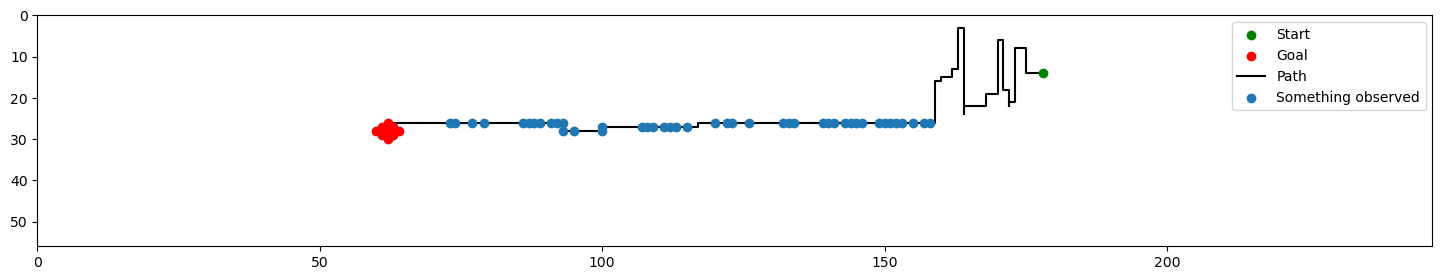

In [29]:
plot_steps(all_sims[1])

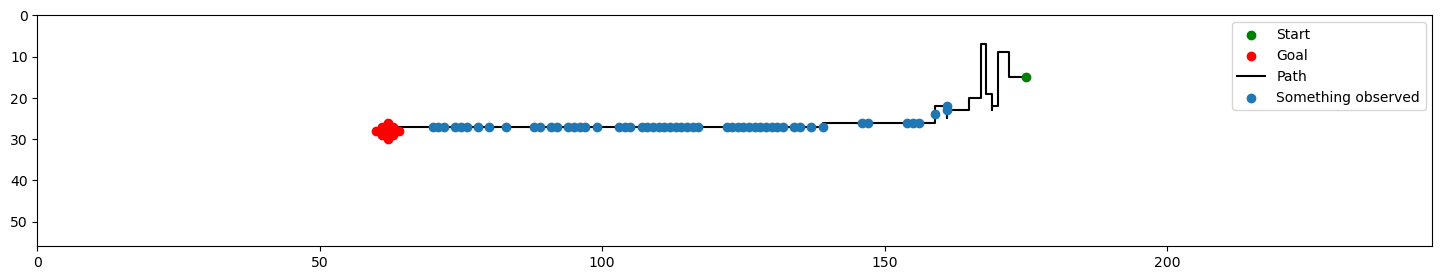

In [30]:
plot_steps(all_sims[2])